In [1]:
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo
from diabetes_utils import clean_diabetes_data, plot_and_save_metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# 1. Load and clean data
diabetes_data = fetch_ucirepo(id=296)
X = diabetes_data.data.features
y = diabetes_data.data.targets

if "readmitted" not in y.columns:
    y.columns = ["readmitted"]

df = pd.concat([X, y], axis=1)
df_clean = clean_diabetes_data(df)

print("Cleaned shape:", df_clean.shape)
print(df_clean.columns)


# 2. Build encounter-level "sequences" (T = 1)
# numeric features used at each encounter
long_feats = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses",
]

# demographic / categorical features
demo_cols = [
    "race",
    "gender",
    "age",
    "diag_1_group",
    "diag_2_group",
    "diag_3_group",
    "insulin",
    "change",
    "diabetesMed",
]

# target label
y_seq = df_clean["readmit_30d"].values
n_samples = df_clean.shape[0]

# longitudinal numeric features as a 3D tensor: (samples, timesteps, features)
X_long = df_clean[long_feats].values      
X_long = X_long.reshape(n_samples, 1, -1) 

# simple time-gap channel: 1 for each real step (no padding here)
X_time = np.ones((n_samples, 1, 1))           # shape (n_samples, 1, 1)

# demographics as one-hot encoded 2D matrix
demo_df = df_clean[demo_cols].copy()
demo_df = pd.get_dummies(demo_df, columns=demo_cols, drop_first=True)
X_demo = demo_df.values                   

print("X_long shape:", X_long.shape)
print("X_time shape:", X_time.shape)
print("X_demo shape:", X_demo.shape)
print("Positive rate:", y_seq.mean().round(3))


# 3. Train–test split and scaling
X_train_long, X_test_long, \
X_train_time, X_test_time, \
X_train_demo, X_test_demo, \
y_train, y_test = train_test_split(
    X_long,
    X_time,
    X_demo,
    y_seq,
    test_size=0.2,
    random_state=42,
    stratify=y_seq,
)

# scale longitudinal numeric features across all time steps
n_long_feats = X_train_long.shape[2]
scaler_long = StandardScaler()

# Convert to 2D for scaling: (samples * timesteps, features)
X_train_long_2d = X_train_long.reshape(-1, n_long_feats)
X_test_long_2d = X_test_long.reshape(-1, n_long_feats)

# Fit scaler on train and transform train/test
X_train_long_2d = scaler_long.fit_transform(X_train_long_2d)
X_test_long_2d = scaler_long.transform(X_test_long_2d)

# Convert back to 3D: (samples, timesteps, features)
X_train_long = X_train_long_2d.reshape(X_train_long.shape)
X_test_long = X_test_long_2d.reshape(X_test_long.shape)


# 4. Define simplified TA-RNN-style model
T = X_train_long.shape[1]            # should be 1
n_demo_features = X_train_demo.shape[1]

# inputs: sequence features, time gap channel, demographics
long_input = Input(shape=(T, n_long_feats), name="longitudinal")
time_input = Input(shape=(T, 1), name="time_gaps")
demo_input = Input(shape=(n_demo_features,), name="demographics")

# attach time gaps to each time step
seq_input = Concatenate(axis=-1)([long_input, time_input])

# LSTM over the (length-1) sequence
x = LSTM(64)(seq_input)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)

# combine sequence representation with demographics
x = Concatenate(axis=-1)([x, demo_input])

output = Dense(1, activation="sigmoid")(x)

ta_rnn_model = Model(
    inputs=[long_input, time_input, demo_input],
    outputs=output,
    name="ta_rnn_simplified",
)

ta_rnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")],
)

ta_rnn_model.summary()

early_stop = EarlyStopping(
    monitor="val_auc",
    patience=2,
    mode="max",
    restore_best_weights=True,
)


# 5. Train model
history = ta_rnn_model.fit(
    [X_train_long, X_train_time, X_train_demo],
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1,
)


# 6. Evaluate and save plots
y_prob = ta_rnn_model.predict([X_test_long, X_test_time, X_test_demo]).ravel()
y_pred = (y_prob >= 0.5).astype(int)

ta_rnn_results = {
    "accuracy": round(accuracy_score(y_test, y_pred), 3),
    "roc_auc": round(roc_auc_score(y_test, y_prob), 3),
    "f1_pos":  round(f1_score(y_test, y_pred, zero_division=0), 3),
}

print("\nTA-RNN-style model results:")
for k, v in ta_rnn_results.items():
    print(f"  {k}: {v}")

# Save plots
plot_and_save_metrics("ta_rnn", y_test, y_prob)

# Save probabilites
np.save("y_test_tarnn.npy", y_test)
np.save("prob_tarnn.npy", y_prob)

C:\Users\Timothy\AppData\Local\Programs\Python\Python39\lib\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Cleaned shape: (101766, 49)
Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_group', 'diag_2_group', 'diag_3_group', 'readmit_30d'],
      dtype='object')
X_long shape: (101766, 1, 8)
X_time shape: (101766, 1,

4/4 [==============================] - 0s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

625/625 [==============================] - 1s 2ms/step


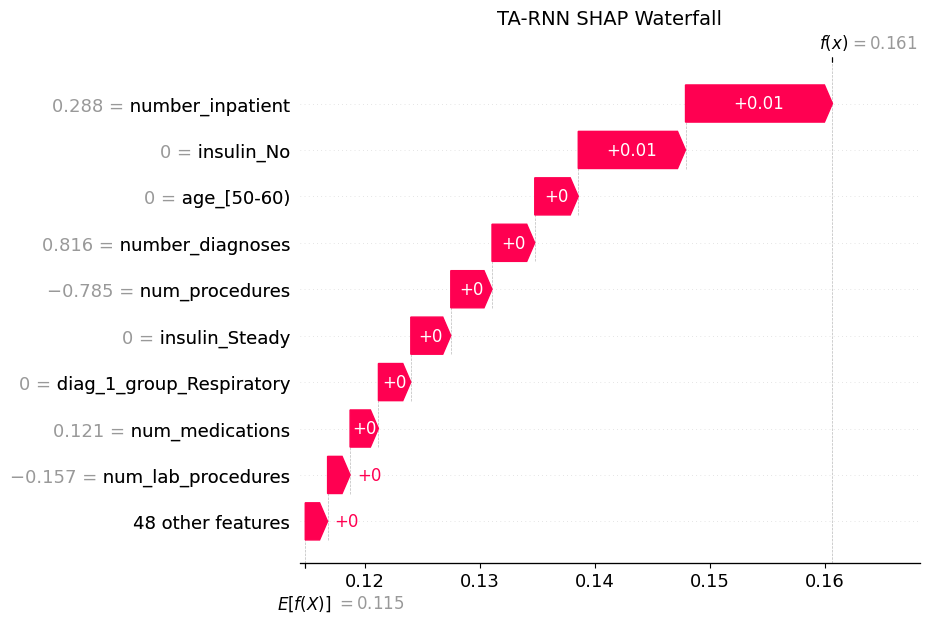

In [6]:
import shap

# Combine features for SHAP
# Flatten sequence (T=1) and time gap channels
X_test_long_flat = X_test_long.reshape(X_test_long.shape[0], -1)  # (samples, n_long_feats)
X_test_time_flat = X_test_time.reshape(X_test_time.shape[0], -1)  # (samples, 1)

# Concatenate all features
X_test_combined = np.hstack([X_test_long_flat, X_test_time_flat, X_test_demo])

# Build feature names
long_feat_names = long_feats
time_feat_names = ["time_gap"]
demo_feat_names = df_clean[demo_cols].copy()
demo_feat_names = pd.get_dummies(demo_feat_names, columns=demo_cols, drop_first=True).columns.tolist()

feature_names = long_feat_names + time_feat_names + demo_feat_names

# Create a small background sample for KernelExplainer
X_train_long_flat = X_train_long.reshape(X_train_long.shape[0], -1)
X_train_time_flat = X_train_time.reshape(X_train_time.shape[0], -1)
X_train_combined = np.hstack([X_train_long_flat, X_train_time_flat, X_train_demo])

background = X_train_combined[np.random.choice(X_train_combined.shape[0], 100, replace=False)]

# Define a prediction function
def ta_rnn_predict(X_combined):
    n_long = X_train_long.shape[2]
    # split combined into original inputs
    X_long = X_combined[:, :n_long].reshape(-1, 1, n_long)
    X_time = X_combined[:, n_long:n_long+1].reshape(-1, 1, 1)
    X_demo = X_combined[:, n_long+1:]
    return ta_rnn_model.predict([X_long, X_time, X_demo]).ravel()

# SHAP KernelExplainer (slow but works)
explainer = shap.KernelExplainer(ta_rnn_predict, background)

# Explain first test instance
shap_values = explainer.shap_values(X_test_combined[0:1], nsamples=200)

# Build Explanation object
exp = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_test_combined[0],
    feature_names=feature_names
)

# Plot waterfall
plt.clf()
shap.initjs()
shap.waterfall_plot(exp, show=False)
plt.title("TA-RNN SHAP Waterfall", fontsize=14)
plt.savefig("figures/shap_ta_rnn_waterfall_plot.png", bbox_inches='tight')
plt.show()